<a href="https://colab.research.google.com/github/alaaguedda/product_sales/blob/main/saudi_product_sales_compitition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

df.head()

IndexError: list index out of range

In [23]:
df.columns = ['Date','Product','City','Sales']
df['Product'] = df['Product'].str.replace('منتج ','')
top3_sales_product = df.groupby('Product')['Sales'].sum().sort_values(ascending=False).nlargest(3)
top3_sales_product

,Sales
Product,
D,87987
B,87466
A,83670


In [24]:
# 1. Total sales per day
daily_sales = df.groupby('Date', as_index=False)['Sales'].sum()
daily_sales.columns = ['Date', 'Total_Sales']

daily_sales

,Date,Total_Sales
0,2025-01-01,19003
1,2025-01-02,10819
2,2025-01-03,15591
3,2025-01-04,9589
4,2025-01-05,18540
5,2025-01-06,15207
6,2025-01-07,16091
7,2025-01-08,15920
8,2025-01-09,14910
9,2025-01-10,10992


In [25]:
# 2. Top 3 products with sales
top_products_daily = (
    df.groupby(['Date', 'Product'], as_index=False)['Sales']
      .sum()
      .sort_values(['Date', 'Sales'], ascending=[True, False])
)
top_products_daily

,Date,Product,Sales
3,2025-01-01,D,4754
0,2025-01-01,A,4039
1,2025-01-01,B,3997
4,2025-01-01,E,3568
2,2025-01-01,C,2645
...,...,...,...
149,2025-01-30,E,4691
147,2025-01-30,C,3624
148,2025-01-30,D,3215
145,2025-01-30,A,1253


In [26]:


# 3. Aggregate into two separate lists (products + sales)
top3_daily = (
    top_products_daily.groupby('Date')
    .apply(lambda x: pd.Series({
        'Top3_Products': x.nlargest(3, 'Sales')['Product'].tolist(),
        'Top3_Product_Sales': x.nlargest(3, 'Sales')['Sales'].tolist()
    }))
    .reset_index()
)
top3_daily


/tmp/ipython-input-3477203544.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,Date,Top3_Products,Top3_Product_Sales
0,2025-01-01,"[D, A, B]","[4754, 4039, 3997]"
1,2025-01-02,"[E, D, B]","[3384, 2606, 1802]"
2,2025-01-03,"[A, B, D]","[4824, 3535, 3000]"
3,2025-01-04,"[A, B, D]","[2486, 2257, 1848]"
4,2025-01-05,"[A, D, E]","[4631, 4617, 4127]"
5,2025-01-06,"[A, E, C]","[4119, 3946, 3104]"
6,2025-01-07,"[D, C, B]","[4158, 3938, 3680]"
7,2025-01-08,"[D, A, B]","[4548, 4483, 2789]"
8,2025-01-09,"[B, D, E]","[4736, 3777, 3211]"
9,2025-01-10,"[A, C, B]","[3669, 3377, 1616]"


In [27]:
# 4. Merge with totals
df_sales_optimized = daily_sales.merge(top3_daily, on='Date')
df_sales_optimized

,Date,Total_Sales,Top3_Products,Top3_Product_Sales
0,2025-01-01,19003,"[D, A, B]","[4754, 4039, 3997]"
1,2025-01-02,10819,"[E, D, B]","[3384, 2606, 1802]"
2,2025-01-03,15591,"[A, B, D]","[4824, 3535, 3000]"
3,2025-01-04,9589,"[A, B, D]","[2486, 2257, 1848]"
4,2025-01-05,18540,"[A, D, E]","[4631, 4617, 4127]"
5,2025-01-06,15207,"[A, E, C]","[4119, 3946, 3104]"
6,2025-01-07,16091,"[D, C, B]","[4158, 3938, 3680]"
7,2025-01-08,15920,"[D, A, B]","[4548, 4483, 2789]"
8,2025-01-09,14910,"[B, D, E]","[4736, 3777, 3211]"
9,2025-01-10,10992,"[A, C, B]","[3669, 3377, 1616]"


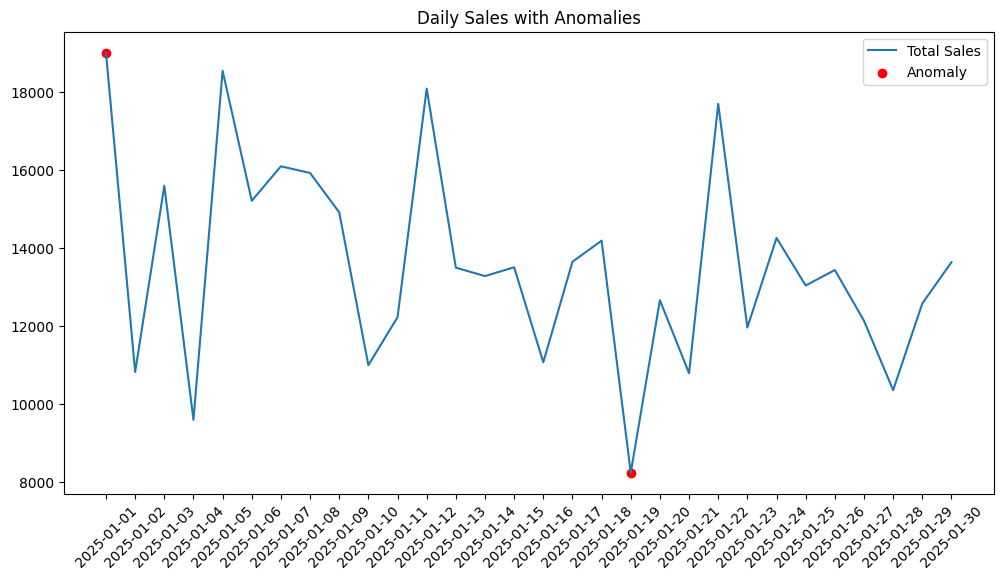

In [28]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Use only Total_Sales for anomaly detection
X = df_sales_optimized[['Total_Sales']]

# Train Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df_sales_optimized['anomaly'] = iso.fit_predict(X)

# -1 = anomaly, 1 = normal
df_sales_optimized['is_anomaly'] = df_sales_optimized['anomaly'] == -1

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_sales_optimized['Date'], df_sales_optimized['Total_Sales'], label="Total Sales")
plt.scatter(
    df_sales_optimized['Date'][df_sales_optimized['is_anomaly']],
    df_sales_optimized['Total_Sales'][df_sales_optimized['is_anomaly']],
    color='red', label="Anomaly"
)
plt.legend()
plt.title("Daily Sales with Anomalies")
plt.xticks(rotation=45)
plt.show()


In [ ]:
!pip install mlxtend

from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd


In [ ]:

# Explode Top3_Products column (so each row = Date, Product)
exploded = df_sales_optimized[['Date','Top3_Products']].explode('Top3_Products')

# Create basket-like pivot table: one row per date, one col per product (1 if product in top3)
basket = pd.crosstab(exploded['Date'], exploded['Top3_Products'])

# Find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort strongest rules
rules = rules.sort_values(by='lift', ascending=False)
rules.head(10)


In [ ]:
df['Region'].unique()

In [ ]:
df.head(10)

In [32]:
df_city_sales = df.groupby(["Date","City", "Product"], as_index=False)["Sales"].sum()
df_city_sales

,Date,City,Product,Sales
0,2025-01-01,الخبر,C,2645
1,2025-01-01,الرياض,A,4039
2,2025-01-01,جدة,B,3997
3,2025-01-01,جدة,D,4754
4,2025-01-01,جدة,E,3568
...,...,...,...,...
145,2025-01-30,الخبر,D,3215
146,2025-01-30,الخبر,E,4691
147,2025-01-30,الدمام,C,3624
148,2025-01-30,الرياض,A,1253
